In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import random

import tqdm

import torchvision
import torchvision.models as models
from torchvision import transforms
import torchvision.datasets

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
from torchvision.models.resnet import conv3x3, _resnet

class PreactBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(PreactBasicBlock, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')

        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        # Both self.conv1 and self.downsample layers downsample the input when stride != 1

        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)

        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out

In [0]:
def are_weigths_unequal(old_weigths, new_weigths):
    return bool(len([1 for w1, w2 in zip(old_weigths, new_weigths) if not torch.all(w1.eq(w2))]))

def cycle(model, loader, criterion, batch_size, train=False, optimizer=None):
    overall_loss = []
    overall_accuracy = []
    dataloader_iterator = iter(loader)

    _ = model.train() if train else model.eval()

    model_weigths = list(model.state_dict().values())

    for batch_id in tqdm.tqdm_notebook(range(len(loader))):   
        try:
            X_batch, y_batch = next(dataloader_iterator)
        except:
            dataloader_iterator = iter(loader)
            X_batch, y_batch = next(dataloader_iterator)

        if batch_id == 2:
            if train:
                assert are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Model is not training"
                
            else:
                assert not are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Weigths are chaning while validating"

            del model_weigths
    
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        if train:
            preds = model(X_batch)

            loss_value = criterion(preds, y_batch)
            loss_value.backward()
    
            optimizer.step()
            optimizer.zero_grad()

        else:
            with torch.no_grad():
                preds = model(X_batch)
                loss_value = criterion(preds, y_batch).mean()

        overall_loss.append(loss_value.mean())

        accuracy = (preds.argmax(dim=1) == y_batch).float().mean().data.cpu()
        overall_accuracy.append(accuracy)

    mean_loss = sum(overall_loss) / len(loader)
    mean_accuracy = sum(overall_accuracy) / len(loader)
    
    return mean_loss.item(), mean_accuracy.item()

In [4]:
# Dataset initialization

batch_size = 64

train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply([transforms.RandomAffine(40)], p=0.3),
                                transforms.RandomApply([transforms.ColorJitter()], p=0.3),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

val_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./', train=False,
                                       download=True, transform=val_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
epochs = 20

model = _resnet('resnet18', PreactBasicBlock, [2, 2, 2, 2], False, False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [6]:
# Training loop

train_loss_history = []
train_accuracy_history = []

val_loss_history = []
val_accuracy_history = []

for epoch in tqdm.tqdm_notebook(range(epochs)):

    train_loss, train_accuracy = cycle(model, trainloader, criterion, batch_size, train=True, optimizer=optimizer)#train(model, trainloader, criterion, optimizer, batch_size)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    val_loss, val_accuracy = cycle(model, testloader, criterion, batch_size)#validate(model, testloader, criterion, batch_size)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    scheduler.step()

    print('Epoch:', epoch+1)
    print('Train: loss', train_loss, 'accuracy', train_accuracy)
    print('Validation: loss', val_loss, 'accuracy', val_accuracy)

print('Best validation accuracy:', max(val_accuracy_history), 'Epoch', val_accuracy_history.index(max(val_accuracy_history))+1)

Epoch: 1
Train: loss 1.4722251892089844 accuracy 0.46817055344581604
Validation: loss 1.2172434329986572 accuracy 0.5573248267173767


Epoch: 2
Train: loss 1.1375083923339844 accuracy 0.5971267819404602
Validation: loss 0.9725757837295532 accuracy 0.6580414175987244


Epoch: 3
Train: loss 0.9751297831535339 accuracy 0.6589474081993103
Validation: loss 0.8948336243629456 accuracy 0.6857085824012756


Epoch: 4
Train: loss 0.8790408968925476 accuracy 0.6941936016082764
Validation: loss 0.812839686870575 accuracy 0.7127786874771118


Epoch: 5
Train: loss 0.8106241226196289 accuracy 0.7177309989929199
Validation: loss 0.7904942631721497 accuracy 0.7259156107902527


Epoch: 6
Train: loss 0.7499313354492188 accuracy 0.7387308478355408
Validation: loss 0.7211633324623108 accuracy 0.7544785141944885


Epoch: 7
Train: loss 0.7048758268356323 accuracy 0.7558144330978394
Validation: loss 0.6855700612068176 accuracy 0.7580612897872925


Epoch: 8
Train: loss 0.656073272228241 accuracy 0.7729379534721375
Validation: loss 0.6627845168113708 accuracy 0.7735868096351624


Epoch: 9
Train: loss 0.6208147406578064 accuracy 0.7849664092063904
Validation: loss 0.6529315114021301 accuracy 0.7794585824012756


Epoch: 10
Train: loss 0.588006317615509 accuracy 0.7953964471817017
Validation: loss 0.6193848252296448 accuracy 0.7859275341033936


Epoch: 11
Train: loss 0.45285123586654663 accuracy 0.8442095518112183
Validation: loss 0.5355919003486633 accuracy 0.8190684914588928


Epoch: 12
Train: loss 0.4063125252723694 accuracy 0.8609734773635864
Validation: loss 0.5304259061813354 accuracy 0.8205612897872925


Epoch: 13
Train: loss 0.3851187229156494 accuracy 0.8669477105140686
Validation: loss 0.5327057838439941 accuracy 0.8215565085411072


Epoch: 14
Train: loss 0.36611196398735046 accuracy 0.8734415173530579
Validation: loss 0.5418120622634888 accuracy 0.8206608295440674


Epoch: 15
Train: loss 0.3506983518600464 accuracy 0.8790760636329651
Validation: loss 0.5384330749511719 accuracy 0.8258360028266907


Epoch: 16
Train: loss 0.3387429416179657 accuracy 0.8827126026153564
Validation: loss 0.5484851002693176 accuracy 0.8244426846504211


Epoch: 17
Train: loss 0.3268369138240814 accuracy 0.8858296275138855
Validation: loss 0.5525719523429871 accuracy 0.821457028388977


Epoch: 18
Train: loss 0.3100963830947876 accuracy 0.8939218521118164
Validation: loss 0.569853663444519 accuracy 0.821954607963562


Epoch: 19
Train: loss 0.3042066991329193 accuracy 0.8954203724861145
Validation: loss 0.5810798406600952 accuracy 0.8211584687232971


Epoch: 20
Train: loss 0.2960819602012634 accuracy 0.8980778455734253
Validation: loss 0.5800890326499939 accuracy 0.8270302414894104

Best validation accuracy: 0.8270302414894104 Epoch 20


Text(0.5, 1.0, 'Accuracy')

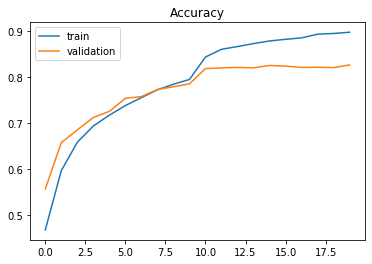

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_history, label="train")
plt.plot(val_accuracy_history, label="validation")
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

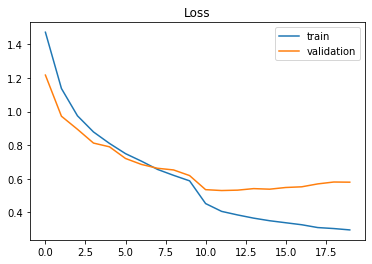

In [8]:
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="validation")
plt.legend()
plt.title('Loss')